In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from joblib import dump
from joblib import load
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

In [2]:
store_sales = pd.read_csv(r'C:\Users\mj\Desktop\ML-\train (gith).csv')

In [3]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [4]:
store_sales = store_sales.drop(['store','item'],axis=1)

In [5]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


In [6]:
store_sales['date'] = pd.to_datetime(store_sales['date'])

In [7]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


In [8]:
#converting the date into a monthe period , then sum the number of item sold in each month :
store_sales['date'] = store_sales['date'].dt.to_period("M")
monthly_sales = store_sales.groupby('date').sum().reset_index()


In [9]:
#convert the resulting t column to time stamb
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()


In [10]:
monthly_sales.head(10)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


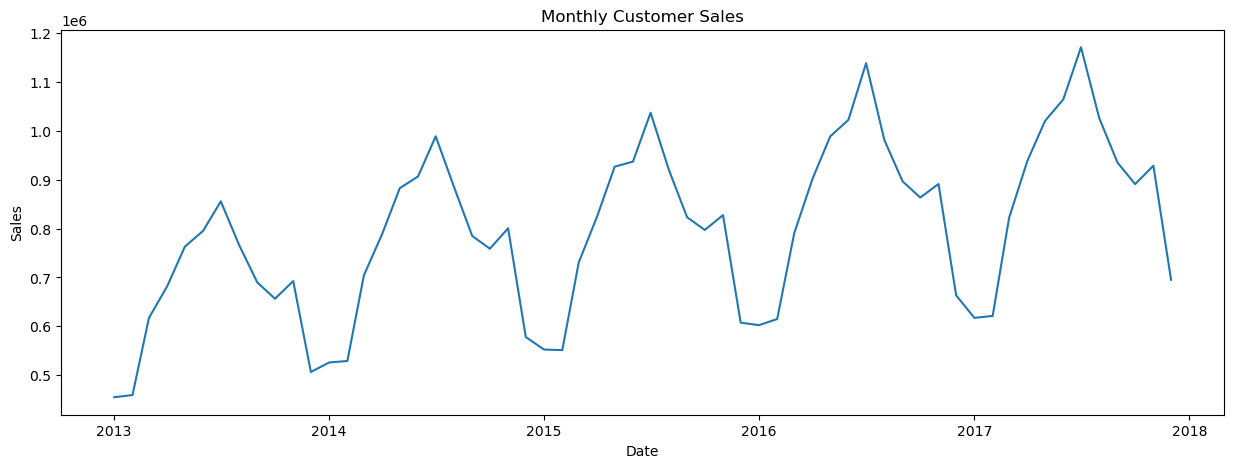

In [11]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Customer Sales')
plt.show()

In [12]:
#data shows an increasing rate over time (Trend: If the data has a noticeable increasing or decreasing trend,)
#so i call the difference on the item count(sales) culomns to make the sales data stationery
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0


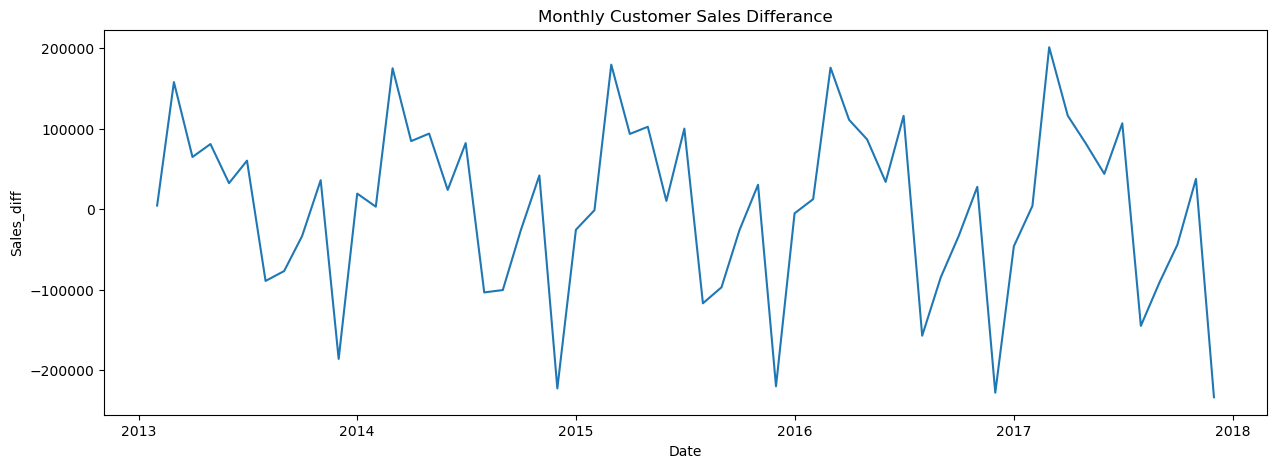

In [13]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales_diff'])
plt.xlabel('Date')
plt.ylabel('Sales_diff')
plt.title('Monthly Customer Sales Differance')
plt.show()

In [14]:
#Dropping off sales and date (non stationary data) to create supervised data
supervised_data = monthly_sales.drop(['date','sales'],axis=1)

In [15]:
#Creating lagged features by shifting supervised_data for 12 months 
for i in range(1, 13):
    col_name = 'month_' + str(i)
    supervised_data[col_name] = supervised_data['sales_diff'].shift(i)

supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


In [16]:
#previous 12 month (everything but the last 12 months_)
train_data = supervised_data[:-12]
#comming 12 month (the last 12 rows of 'supervised_data)
test_data = supervised_data[-12:]

#printing the shape of train_test to make sure our dataset is appropriate for our logic
print('Train data shape : ',train_data.shape)
print('Test data shape : ',test_data.shape)




Train data shape :  (35, 13)
Test data shape :  (12, 13)


In [17]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [18]:
#in the supervised data ; the first column is the output and the remaining act as the input

x_train, y_train = train_data[:,1:], train_data[:,0:1]
x_test, y_test = test_data[:,1:] , test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print('x_train shape : ',x_train.shape)
print('y_train shape : ',y_train.shape)
print('x_test shape : ',x_test.shape)
print('y_test shape : ',y_test.shape)

x_train shape :  (35, 12)
y_train shape :  (35,)
x_test shape :  (12, 12)
y_test shape :  (12,)


In [19]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [20]:
actual_sales = monthly_sales['sales'][-13:].tolist()
print(actual_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


In [21]:
# LinearRegression model + the pridected output
lr_model = LinearRegression()
lr_model.fit(x_train,y_train)
lr_predict = lr_model.predict(x_test)

In [22]:
#transforme the predicted values to the origenal scale 
lr_predict = lr_predict.reshape(-1,1)
#this is a matrix- contain the iput features of the test data and the predicted output
lr_pre_test_set = np.concatenate([lr_predict,x_test],axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [23]:
#calculate the predicted sale values and append it to a result_list
result_list = []
for index in range(0,len(lr_pre_test_set)):
    result_list.append(lr_pre_test_set[index][0] + actual_sales[index])
lr_pre_series = pd.Series(result_list,name='Linear Prediction')
predict_df = predict_df.merge(lr_pre_series, left_index = True, right_index = True)
predict_df['Linear Prediction'] = predict_df['Linear Prediction'].round(2)

print(predict_df)

         date  Linear Prediction
0  2017-01-01          647914.79
1  2017-02-01          628337.38
2  2017-03-01          819519.00
3  2017-04-01          943639.12
4  2017-05-01         1033652.95
5  2017-06-01         1065286.25
6  2017-07-01         1201561.20
7  2017-08-01         1002123.50
8  2017-09-01          941514.23
9  2017-10-01          908064.65
10 2017-11-01          916746.05
11 2017-12-01          694797.80


In [24]:
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'],monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'],monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_df['Linear Prediction'],monthly_sales['sales'][-12:])
print('Linear Regression MSE = ', lr_mse)
print('Linear Regression MAE = ', lr_mae)
print('Linear Regression R2 = ', lr_r2)

Linear Regression MSE =  16221.273522537716
Linear Regression MAE =  12433.184999999989
Linear Regression R2 =  0.9906152502910808


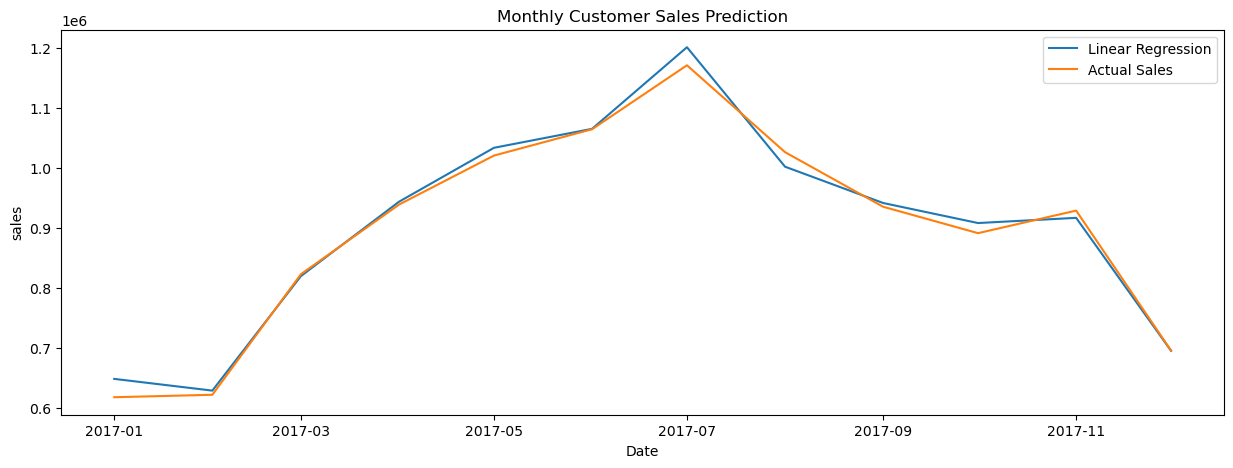

         Date  Predicted Sales
0  2017-01-01        647914.79
1  2017-02-01        628337.38
2  2017-03-01        819519.00
3  2017-04-01        943639.12
4  2017-05-01       1033652.95
5  2017-06-01       1065286.25
6  2017-07-01       1201561.20
7  2017-08-01       1002123.50
8  2017-09-01        941514.23
9  2017-10-01        908064.65
10 2017-11-01        916746.05
11 2017-12-01        694797.80


In [25]:
# Plotting the predicted values
plt.figure(figsize=(15, 5))
plt.plot(predict_df['date'], predict_df['Linear Prediction'], label='Linear Regression')
plt.plot(monthly_sales['date'][-12:], monthly_sales['sales'][-12:], label='Actual Sales')
plt.xlabel('Date')
plt.ylabel('sales')
plt.title('Monthly Customer Sales Prediction')
plt.legend()
plt.show()

# Printing the predicted values in a table format
prediction_table = predict_df[['date', 'Linear Prediction']]
prediction_table.columns = ['Date', 'Predicted Sales']
print(prediction_table)


In [26]:



# Calculate testing error
test_predictions = result_list  # Already calculated in your code
test_mse = np.sqrt(mean_squared_error(test_predictions, monthly_sales['sales'][-12:]))
test_mae = mean_absolute_error(test_predictions, monthly_sales['sales'][-12:])
test_r2 = r2_score(test_predictions, monthly_sales['sales'][-12:])
print('Testing MSE:', test_mse)
print('Testing MAE:', test_mae)
print('Testing R2:', test_r2)


Testing MSE: 16221.272385416854
Testing MAE: 12433.184266490736
Testing R2: 0.9906152516380969
